# Error Mitigation using noise-estimation circuit

In [90]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, IBMQ
from qiskit.circuit import Gate
from qiskit.tools.visualization import plot_histogram
from typing import Union
import numpy as np
import math
import matplotlib.pyplot as plt

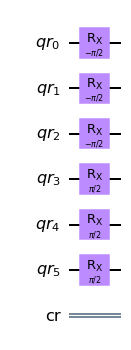

In [58]:
qr = QuantumRegister(size = 6, name = 'qr')
cr = ClassicalRegister(1,name='cr')
circ = QuantumCircuit(qr,cr)

circ.rx(-np.pi/2,qr[0])
circ.rx(-np.pi/2,qr[1])
circ.rx(-np.pi/2,qr[2])
circ.rx(np.pi/2,qr[3])
circ.rx(np.pi/2,qr[4])
circ.rx(np.pi/2,qr[5])


In [24]:
def one_time_step(num_qubits, J, to_gate=True) -> Union[Gate, QuantumCircuit]:
    # Define the circuit for one_time_step
    # J: the value of J*dt
    
    qr = QuantumRegister(num_qubits,name='qr')
    qc = QuantumCircuit(qr)
    
    for i in range( (num_qubits-1)//2):
        qc.cnot(qr[1+2*i],qr[2+2*i])
        qc.rx(-J,qr[2*i+1])
        qc.rz(-J,qr[2*i+2])
        qc.cnot(qr[1+2*i],qr[2+2*i])
        
    for i in range(num_qubits//2):
        qc.cnot(qr[2*i],qr[2*i+1])
        qc.rx(-2*J,qr[2*i])
        qc.rz(-2*J,qr[2*i+1])
        qc.cnot(qr[2*i],qr[2*i+1])
        
    for i in range( (num_qubits-1)//2):
        qc.cnot(qr[1+2*i],qr[2+2*i])
        qc.rx(-J,qr[2*i+1])
        qc.rz(-J,qr[2*i+2])
        qc.cnot(qr[1+2*i],qr[2+2*i])
        
    return qc.to_gate(label=' one time step') if to_gate else qc
        

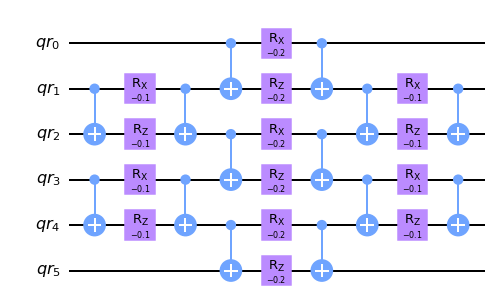

In [25]:
temp_circ = one_time_step(6, 0.1,to_gate=False)
temp_circ.draw('mpl')

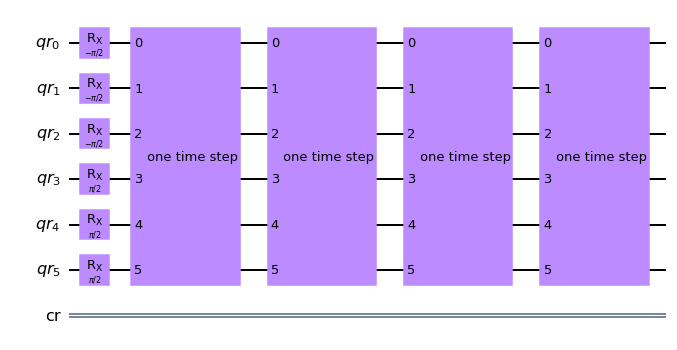

In [59]:
J = 0.25
step = 4

for i in range(step):
    circ.append(one_time_step(6, J), qr)
    
circ.draw('mpl')

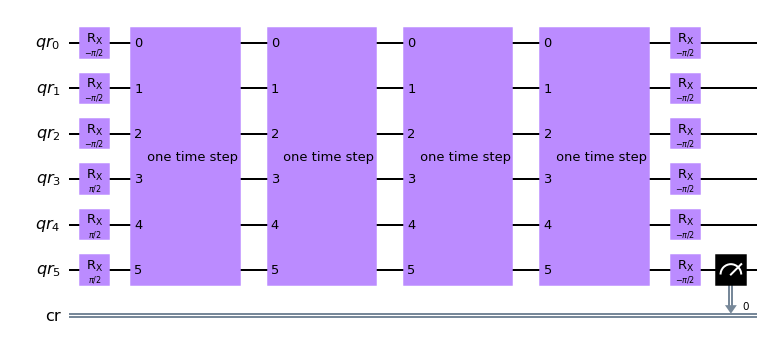

In [60]:
for i in range(6):
    circ.rx(-np.pi/2,qr[i])
    

circ.measure(qr[5],cr)

circ.draw('mpl')
    


In [61]:
simulator = Aer.get_backend('aer_simulator')

circ_transpiled = transpile(circ, simulator)

job = simulator.run(circ_transpiled, shots = 8192)

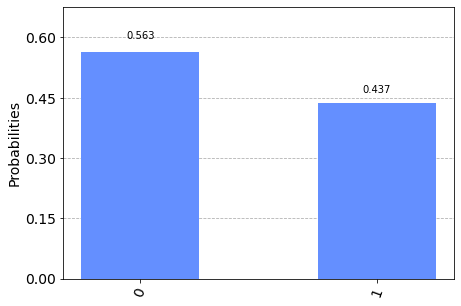

In [62]:
res = job.result()
counts = res.get_counts()
plot_histogram(counts)


In [103]:
def HeiSim_Step_Original(num_qubits, J, step, real_device=False):
    
    qr = QuantumRegister(size = num_qubits, name = 'qr')
    cr = ClassicalRegister(1,name='cr')
    circ = QuantumCircuit(qr,cr)

    circ.rx(-np.pi/2,qr[0])
    circ.rx(-np.pi/2,qr[1])
    circ.rx(-np.pi/2,qr[2])
    circ.rx(np.pi/2,qr[3])
    circ.rx(np.pi/2,qr[4])
    circ.rx(np.pi/2,qr[5])
    
    for i in range(step):
        circ.append(one_time_step(num_qubits, J), qr)
    
    for i in range(6):
        circ.rx(-np.pi/2,qr[i])
    
    circ.measure(qr[5],cr)
    
    if real_device:
        provider = IBMQ.get_provider(hub='ibm-q-community',group='ibmquantumawards',project='open-science-22')
        backend = provider.get_backend(name='ibmq_jakarta')
    else:
        backend = Aer.get_backend('aer_simulator')
    
    circ_transpiled = transpile(circ, backend)
    job = backend.run(circ_transpiled, shots = 8192)
    res = job.result()
    counts = res.get_counts()
    
    counts_0 = counts.get('0')
    counts_1 = counts.get('1')
    if counts_0!=8192 and counts_1!=8192:
        return (counts.get('0') - counts.get('1'))/8192 
    elif counts_0==8192:
        return 1
    elif counts_1==8192:
        return -1

In [ ]:
M = []
for i in range(15):
    temp = HeiSim_Step_Original(num_qubits = 6, J = 0.1,step = i)
    M.append(temp)
    
t = 0.2*np.array(range(15))
plt.plot(t,M)

In [ ]:
HeiSim_Step_Original(num_qubits = 6, J = 0.2,step = 1,real_device=True)